# Plotting Time v PBL Height + Exploring Other Variables

In [1]:
# import the basics
import pysr
from pysr import PySRRegressor

import xarray as xr
import netCDF4 as nc
import h5netcdf
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from glob import glob

# sara also has
from netCDF4 import Dataset
import os

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
folder_path = '/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/'

nc_test1 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_I.nc'), mode='r')
z_256 = nc_test1.variables['z'][:]
zh_257 = nc_test1.variables['zh'][:]
t_120 = nc_test1.variables['time'][:]

nc_test2 = nc.Dataset(os.path.join(folder_path, 'Ug2Q010_IV.nc'), mode='r')
z_384 = nc_test2.variables['z'][:]
zh_385 = nc_test2.variables['zh'][:]
t_90 = nc_test2.variables['time'][:]
print(len(z_256), len(zh_257), len(t_120), len(z_384), len(zh_385), len(t_90))

256 257 120 384 385 90


In [3]:
def read_data(filepath):
    """
    Reads in each dataset and returns an xarray dataset
    """

    ds_thm = xr.open_dataset(f"{filepath}",
                             decode_times=False, group="thermo")
    ds_bud = xr.open_dataset(f"{filepath}",
                            decode_times=False, group="budget")
    ds_def = xr.open_dataset(f"{filepath}", 
                             decode_times=False, group="default")
    ds = xr.merge([ds_thm, ds_bud, ds_def], join="inner")

    if len(ds.time) == 90:
        ds = ds.assign_coords({"time": t_90}).swap_dims({"time":"time"})
    elif len(ds.time) == 120:
        ds = ds.assign_coords({"time": t_120}).swap_dims({"time":"time"})

    if len(ds.z) == 256:
        ds = ds.assign_coords({"z": z_256}).swap_dims({"z":"z"})
    elif len(ds.z) == 384:
        ds = ds.assign_coords({"z": z_384}).swap_dims({"z":"z"})

    if len(ds.zh) == 257:
        ds = ds.assign_coords({"zh": zh_257}).swap_dims({"zh":"zh"})
    elif len(ds.zh) == 385:
        ds = ds.assign_coords({"zh": zh_385}).swap_dims({"zh":"zh"})

    return ds

* Four inversion cases, i being the strong inversion and iv the weakest (temperature inversion that occurs at the top of the ABL)
* Surface Heating (Q): Influences the heat profile.
* Wind (Ug): Imposed wind; affects the movement and distribution of air properties.
* Inversion (dtheta/dz): Impacts the stratification and stability, influencing PBL growth.

In [5]:
# renaming files according to their inversion strength, wind, and surface heating
folder_path = '/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/'
files = glob(f"{folder_path}/*")

for file in files:
    print(file)

/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q006_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q006_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q010_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q024_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_III.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q001_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q01_III.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q003_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q010_I.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug1Q01_II.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug8Q003_II.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug16Q000_IV.nc
/Users/gretavanzetten/Desktop/LEAPSummer2024/les_sim_2/Ug2Q010_IV.nc
/Users/gretavanzetten/Desktop/LE

In [10]:
i16_6 = read_data(files[0])
iv8_6 = read_data(files[1])
iv8_3 = read_data(files[2])
iv16_10 = read_data(files[3])
i2_24 = read_data(files[4])
iii8_3 = read_data(files[5])
iv16_10 = read_data(files[6])
iii2_1 = read_data(files[7])
iv16_3 = read_data(files[8])
i2_10 = read_data(files[9])
ii1_1 = read_data(files[10])
iii8_3 = read_data(files[11])
#iv16_0 = read_data(files[12])
iv2_10 = read_data(files[13])
iv16_6 = read_data(files[14])


### Helpful Variable Names
* pbl_height = 'zi' 
* mean potential temperature = 'th'
* heat_flux = 'th_flux' 
* time = 'time'

Text(0.5, 1.0, 'Plot 1: Time vs PBL Height (Ug=2, Q=20)')

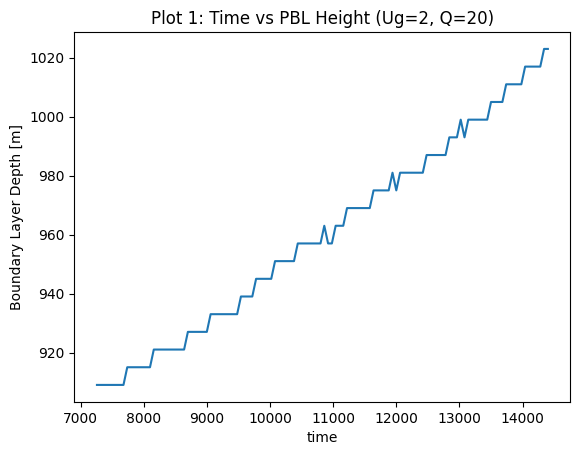

In [18]:
# plot time v pbl height (not time averaged)
i2_24_plot = i2_24[["zi", "th", "th_flux"]]

i2_24_plot.zi.plot()
plt.title("Plot 1: Time vs PBL Height (Ug=2, Q=20)")

In [15]:
def time_average(data_array, timeavg):
    """
    Parameters:
    - data_array (xarray.DataArray),input data array with 'time' dimension
    - timeavg (int), number of time steps to average over

    Returns:
    - xarray.DataArray, time-averaged data array.
    """
    # make sure timeavg is positive int + smaller than the length of data
    if timeavg <= 0 or timeavg > data_array.sizes["time"]:
        raise ValueError("timeavg must be a positive integer less than or equal to the number of time steps in data.")

    # resample data array by averaging over specified intervals
    averaged_data_array = data_array.coarsen(time=timeavg, boundary="trim").mean()

    return averaged_data_array

Text(0.5, 1.0, 'Plot 2: Time (Averaged over 15 sec) vs PBL Height (Ug=2, Q=20)')

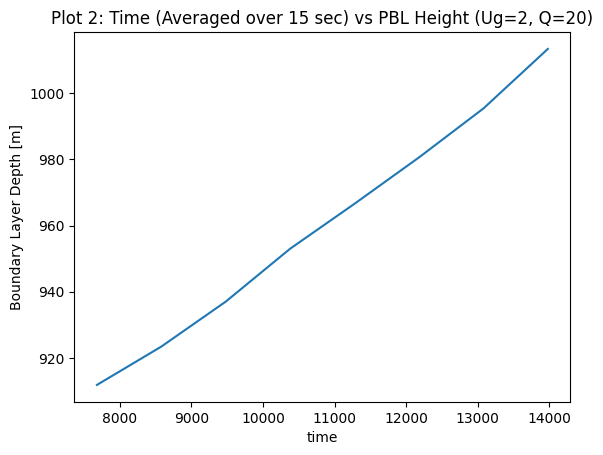

In [19]:
i2_24_avg = time_average(i2_24, 15)

i2_24_avg_plot = i2_24_avg[["zi", "th", "th_flux"]]

i2_24_avg_plot.zi.plot()
plt.title("Plot 2: Time (Averaged over 15 sec) vs PBL Height (Ug=2, Q=20)")

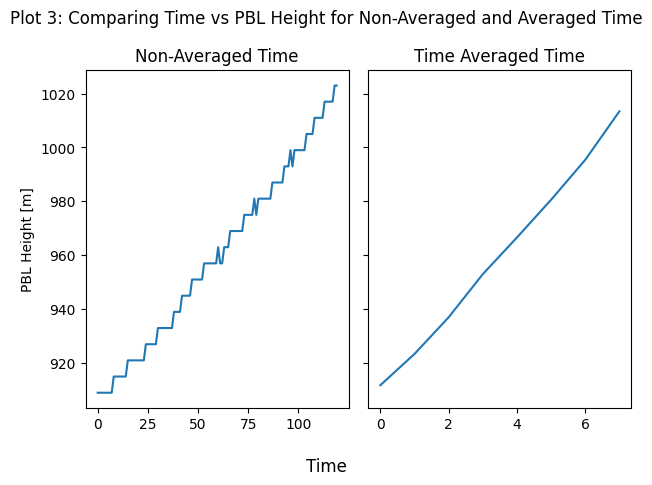

In [20]:
# comparing time averaged v non-time averaged time vs pbl height
# not sure how to adjsut time on the bottom to actually be displayed in seconds

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

fig.suptitle('Plot 3: Comparing Time vs PBL Height for Non-Averaged and Averaged Time')

ax1.plot(i2_24_plot.zi)
ax1.set_title(f"Non-Averaged Time")
ax1.set_ylabel("PBL Height [m]")

ax2.plot(i2_24_avg_plot.zi)
ax2.set_title(f"Time Averaged Time")
fig.supxlabel("Time")

plt.tight_layout()

Working on displaying multiple time averaged plots next to each other to compare the different files

In [28]:
# preparing files for plotting by time averaging
iv16_3avg = time_average(iv16_3, 15)
iv16_6avg = time_average(iv16_6, 15)
iii8_3avg = time_average(iii8_3, 15)
ii10_1avg = time_average(ii1_1, 15)
i16_6avg = time_average(i16_6, 15)
i2_10avg = time_average(i2_10, 15)

iv16_3avg_plt = iv16_3avg[["zi", "th", "th_flux"]]
iv16_6avg_plt = iv16_6avg[["zi", "th", "th_flux"]]
iii8_3avg_plt = iii8_3avg[["zi", "th", "th_flux"]]
ii10_1avg_plt = ii10_1avg [["zi", "th", "th_flux"]]
i16_6avg_plt = i16_6avg[["zi", "th", "th_flux"]]
i2_10avg_plt = i2_10avg[["zi", "th", "th_flux"]]

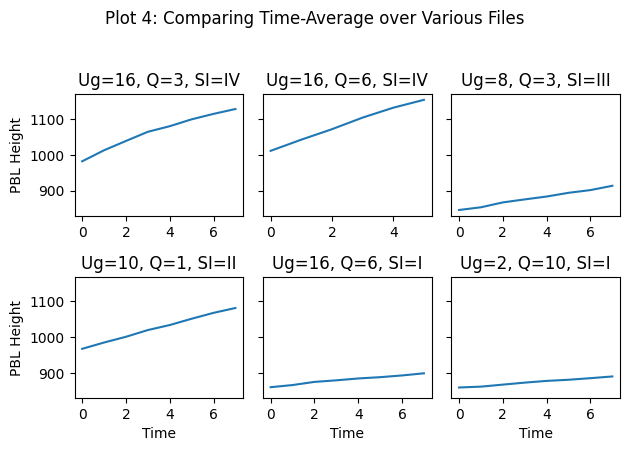

In [34]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True)

fig.suptitle('Plot 4: Comparing Time-Average over Various Files')

ax1.plot(iv16_3avg_plt.zi)
ax1.set_title("Ug=16, Q=3, SI=IV")
ax1.set_ylabel("PBL Height")

ax2.plot(iv16_6avg_plt.zi)
ax2.set_title("Ug=16, Q=6, SI=IV")

ax3.plot(iii8_3avg_plt.zi)
ax3.set_title("Ug=8, Q=3, SI=III")

ax4.plot(ii10_1avg_plt.zi)
ax4.set_title("Ug=10, Q=1, SI=II")
ax4.set_ylabel("PBL Height")
ax4.set_xlabel("Time")

ax5.plot(i16_6avg_plt.zi)
ax5.set_title("Ug=16, Q=6, SI=I")
ax5.set_xlabel("Time")

ax6.plot(i2_10avg_plt.zi)
ax6.set_title("Ug=2, Q=10, SI=I")
ax6.set_xlabel("Time")

plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.show()